# **Audio Engagement Challenge**
*Project made by Hanna Krechyk and Jakub Cisek*

# Agenda
1. Overview of the challenge, process and structure of the work
2. Data Collection
3. Descriptive Statistics
4. Handling Outliers
5. Data Visualization and Correlation Analysis
6. Feature Engineering
7. Label Encoding
8. General Observations and Summary

# 1. Overview of the challenge, process and structure of the work

## 1.1 Overview of the challenge

The goal is to predict how long a user will listen to an audio episode, based on a range of feature data describing both the listener and the audio content.

The dataset was synthetically generated based on real-world user audio consumption patterns. Feature distributions are realistic but not identical to any publicly available dataset.

**train.csv** - the training dataset; `Listening_Time_minutes` is the target variable

**test.csv** - the test dataset; your objective is to predict the `Listening_Time_minutes` for each row

**sample_submission.csv** - a sample submission file in the correct format.

## 1.2 Process and structure of the work

1. First, we decided to divide the work into days and set deadlines for all stages. Our plan was as follows:
- EDA development – ​​4 days
- Model selection and forecasting – 7 days
- Final review, inference, debugging – 3 days
2. We then determined that the best way to gain the most insights and analyze data from different angles was to create two separate EDAs. After the deadline, we met to discuss the main findings and exchange thoughts.
3. We began modeling in two separate notebooks, meeting each evening to share experiences and summarize our approaches.
4. After selecting the best model, we compiled our overall EDA, the notebook with the model and observations and the GitHub repository.
5. We expected first place, or at least admission to the Data Science Club :)

# 2. Data Collection

## 2.1 Import Data and Required Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import os
import zipfile
import time
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
import statistics
from sklearn.preprocessing import LabelEncoder

# 2.2 Import the DataSet

In [2]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('audio-engagement-challenge', path='data')

In [3]:
path_to_zip_file = "data/audio-engagement-challenge.zip"
dir_to_extract="data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

In [4]:
print(kaggle.api.competition_list_files('audio-engagement-challenge').files)

[{"ref": "", "name": "sample_submission.csv", "description": "", "totalBytes": 3500026, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "test.csv", "description": "", "totalBytes": 21277250, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "train.csv", "description": "", "totalBytes": 70036578, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}]


# 2.3 Import the CSV Data as Pandas DataFrame

In [13]:
start = time.time()
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
print("Files loaded in", time.time()-start, "seconds")

Files loaded in 2.107354164123535 seconds


# 3. Descriptive Statistics

## 3.1 Basic Information about the data set

In [7]:
print("="*70)
print("BASIC INFORMATION ABOUT THE TRAINING SET")
print("="*70)
print(f"\nDataset dimensions: {train.shape[0]} rows × {train.shape[1]} columns")
print(f"Size in memory: {train.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nTarget: Listening_Time_minutes")

BASIC INFORMATION ABOUT THE TRAINING SET

Dataset dimensions: 750000 rows × 12 columns
Size in memory: 281.7 MB

Target: Listening_Time_minutes


In [8]:
print("="*70)
print("BASIC INFORMATION ABOUT THE TESTING SET")
print("="*70)
print(f"\nDataset dimensions: {test.shape[0]} rows × {test.shape[1]} columns")
print(f"Size in memory: {test.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

BASIC INFORMATION ABOUT THE TESTING SET

Dataset dimensions: 250000 rows × 11 columns
Size in memory: 92.0 MB


In [12]:
print("Range of indexes of the training dataset:", train.index)
print("Range of indexes of the testing dataset:", test.index)

Range of indexes of the training dataset: RangeIndex(start=0, stop=750000, step=1)
Range of indexes of the testing dataset: RangeIndex(start=0, stop=250000, step=1)


In [11]:
print("Columns of the training dataset:",train.columns)
print("Columns of the testing dataset:",test.columns)

Columns of the training dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')
Columns of the testing dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')


**Show top 5 records**

In [14]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [15]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


**Show 5 last records**

In [16]:
train.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939
749999,749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.94439


In [17]:
test.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive
249999,999999,Brain Boost,Episode 46,78.05,Education,41.72,Friday,Morning,50.77,0.0,Negative


**Check duplicates**

In [18]:
print("Duplicates for the training dataset:",train.duplicated().sum())
print("Duplicates for the testing dataset:",test.duplicated().sum())
print("Duplicates for the training dataset:",train.duplicated().sum())

Duplicates for the training dataset: 0
Duplicates for the testing dataset: 0
Duplicates for the training dataset: 0


**There are no duplicates**

**Check data types**

In [19]:
train.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

In [20]:
test.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

## 3.2 Missing values and data structure

### 3.2.1 General overview 

**Check unique values**

In [21]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [22]:
test.nunique()

id                             250000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          11631
Genre                              10
Host_Popularity_percentage       8010
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage      9961
Number_of_Ads                       6
Episode_Sentiment                   3
dtype: int64

In [23]:
num_features = [feature for feature in train.columns if train[feature].dtype != 'O']
cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(train[cat].unique())))

We have 6 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


In [24]:
num_features = [feature for feature in test.columns if test[feature].dtype != 'O']
cat_features = [feature for feature in test.columns if test[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(test[cat].unique())))

We have 5 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


In [26]:
print("="*70)
print("DATA COMPLETENESS")
print("="*70)

print("MISSING VALUES")
print("="*70)

missing = pd.DataFrame({
    'Column': train.columns,
    'Number_of_missing_values': train.isnull().sum(),
    'Percent': (train.isnull().sum() / len(train) * 100).round(2)
})
missing = missing[missing['Number_of_missing_values'] > 0].sort_values('Percent', ascending=False)

if len(missing) > 0:
    print(missing.to_string(index=False))
else:
    print("No missing values ​​in the dataset")

DATA COMPLETENESS
MISSING VALUES
                     Column  Number_of_missing_values  Percent
Guest_Popularity_percentage                    146030    19.47
     Episode_Length_minutes                     87093    11.61
              Number_of_Ads                         1     0.00


### Conclusions: Data Structure

**Numerical Variables (5):**
- Episode_Length_minutes (11.6% missing)
- Host_Popularity_percentage
- Guest_Popularity_percentage (19.5% missing)
- Number_of_Ads
- Listening_Time_minutes (target)

**Category Variables (6):**
- Podcast_Name (48 unique values)
- Episode_Title (100 unique values)
- Genre (10 categories)
- Publication_Day (7 days of the week)
- Publication_Time (4 times of day)
- Episode_Sentiment (3 categories: Positive/Neutral/Negative)

**Observations:**
- Missing values ​​in Guest_Popularity_percentage likely indicate episodes without a guest
- Missing values ​​in Episode_Length_minutes require further analysis and imputation strategy

### 3.2.2 Missing data analysis

In [28]:
print("="*70)
print("MISSING DATA PATTERN ANALYSIS")
print("="*70)

# Episode_Length missing pattern
print("\n1. EPISODE_LENGTH_MINUTES (11.6% missing values)")
print("-" * 50)
train_clean = train.copy()
train_clean['length_missing'] = train_clean['Episode_Length_minutes'].isna().astype(int)

# Per Genre
missing_by_genre = train_clean.groupby('Genre')['length_missing'].agg(['mean', 'sum', 'count'])
missing_by_genre.columns = ['Missing_Rate', 'Missing_Count', 'Total']
missing_by_genre['Missing_Rate'] = (missing_by_genre['Missing_Rate'] * 100).round(2)
missing_by_genre = missing_by_genre.sort_values('Missing_Rate', ascending=False)

print("\nMissing rate per Genre:")
print(missing_by_genre)

# Test chi-squared dla niezależności
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(train_clean['Genre'], train_clean['length_missing'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nTest chi-squared (Genre vs Missing):")
print(f"Chi2 statistics: {chi2:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("CONCLUSION: Missing items are NOT random - there is a connection with Genre")
else:
    print("CONCLUSION: Missing items are random relative to Genre")

# Guest_Popularity missing
print("\n\n2. GUEST_POPULARITY_PERCENTAGE (19.5% missing values)")
print("-" * 50)

train_clean['guest_missing'] = train_clean['Guest_Popularity_percentage'].isna().astype(int)

guest_missing_genre = train_clean.groupby('Genre')['guest_missing'].agg(['mean', 'sum', 'count'])
guest_missing_genre.columns = ['Missing_Rate', 'Missing_Count', 'Total']
guest_missing_genre['Missing_Rate'] = (guest_missing_genre['Missing_Rate'] * 100).round(2)
guest_missing_genre = guest_missing_genre.sort_values('Missing_Rate', ascending=False)

print("\nMissing rate per Genre:")
print(guest_missing_genre)

# Is the target different for missing vs non-missing?
with_guest = train_clean[train_clean['Guest_Popularity_percentage'].notna()]
without_guest = train_clean[train_clean['Guest_Popularity_percentage'].isna()]

mean_with = with_guest['Listening_Time_minutes'].mean()
mean_without = without_guest['Listening_Time_minutes'].mean()
print(f"\nAverage listening time:")
print(f"With a guest: {mean_with:.2f} min")
print(f"Without a guest: {mean_without:.2f} min")
print(f"Difference: {mean_with - mean_without:.2f} min")

# T-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(with_guest['Listening_Time_minutes'],
                           without_guest['Listening_Time_minutes'])
print(f"\nT-test: t={t_stat:.3f}, p-value={p_val:.4f}")
if p_val < 0.05:
    print("CONCLUSION: The difference is statistically significant")
else:
    print("CONCLUSION: No statistically significant difference")

MISSING DATA PATTERN ANALYSIS

1. EPISODE_LENGTH_MINUTES (11.6% missing values)
--------------------------------------------------

Missing rate per Genre:
            Missing_Rate  Missing_Count  Total
Genre                                         
Technology         12.07          10407  86256
Sports             12.04          10544  87606
News               12.02           7621  63385
Education          11.89           5836  49100
Comedy             11.68           9511  81453
Business           11.50           9262  80521
True Crime         11.42           9710  85059
Music              11.37           7134  62743
Health             11.16           7971  71416
Lifestyle          11.03           9097  82461

Test chi-squared (Genre vs Missing):
Chi2 statistics: 95.84, p-value: 0.0000
CONCLUSION: Missing items are NOT random - there is a connection with Genre


2. GUEST_POPULARITY_PERCENTAGE (19.5% missing values)
--------------------------------------------------

Missing rate per G

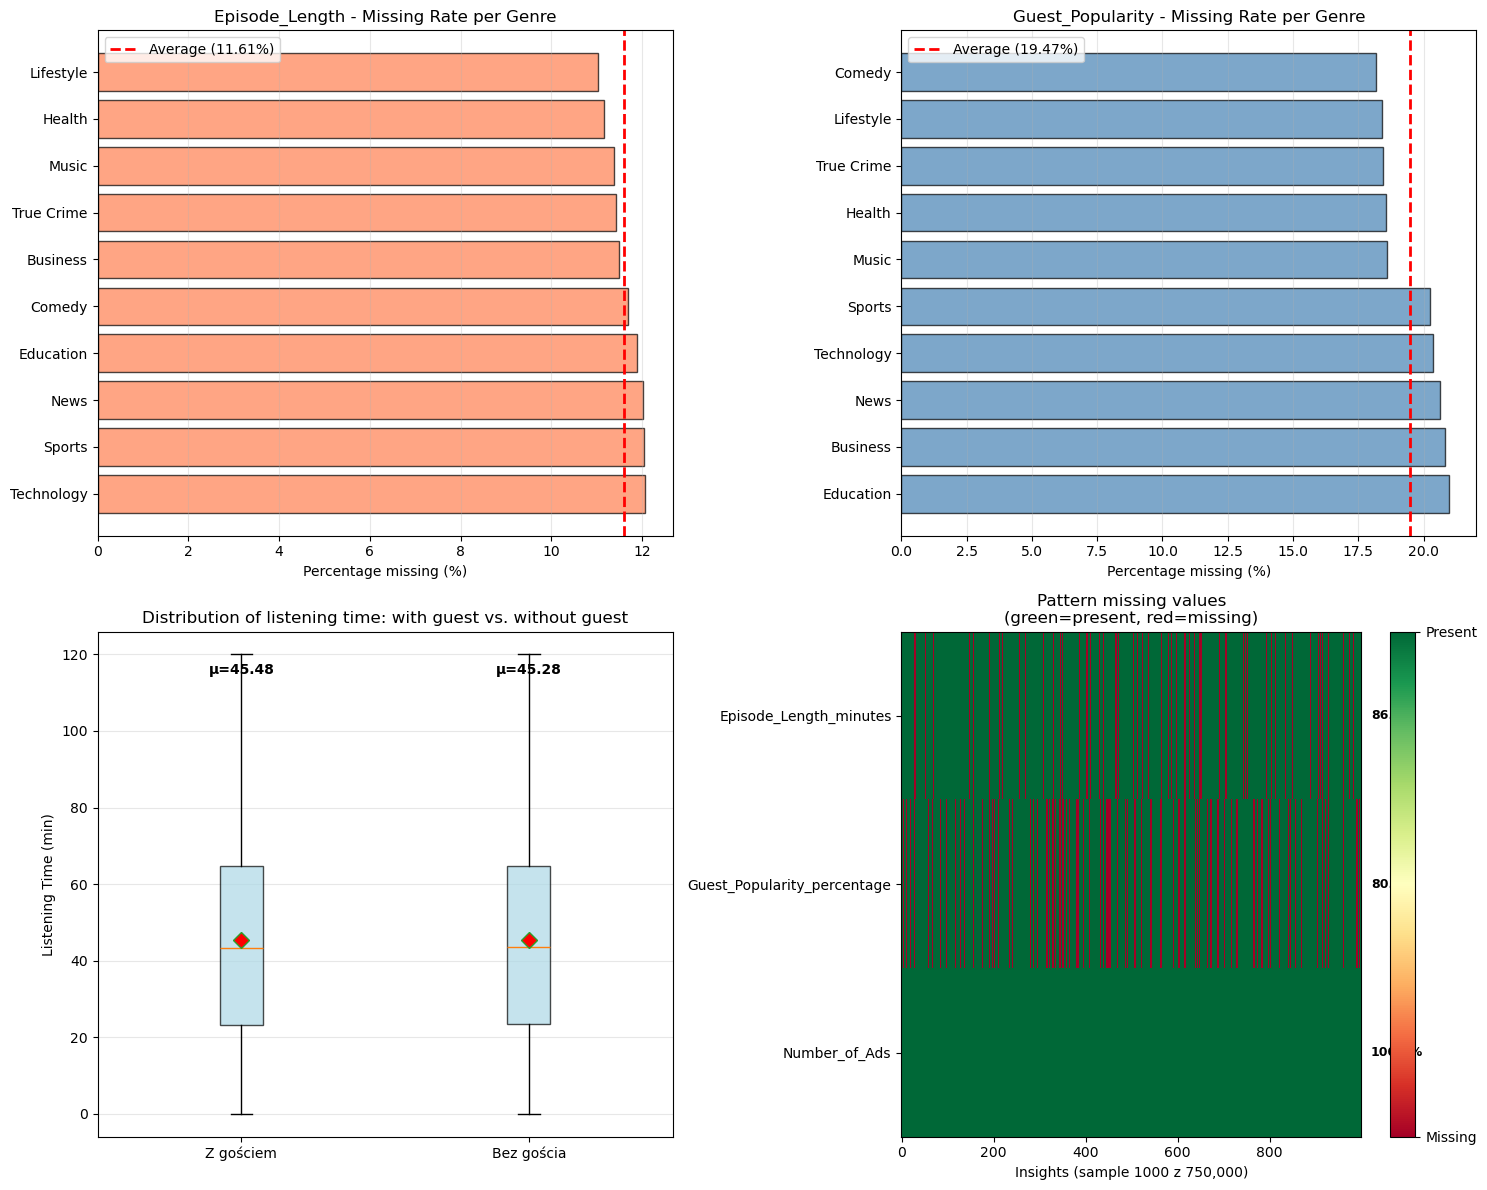


MISSINHNESS CORRELATION

Missingness correlation (0 = independent, 1 = zawsze razem):
                          Episode_Length_missing  Guest_Popularity_missing
Episode_Length_missing                  1.000000                  0.054805
Guest_Popularity_missing                0.054805                  1.000000

CONCLUSION: The missing values ​​are independent - they occur randomly
This is good news - easier imputation


In [29]:
# Visualization of missing data patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Missing rate per Genre - Episode_Length
axes[0, 0].barh(range(len(missing_by_genre.index)), missing_by_genre['Missing_Rate'],
                color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(missing_by_genre.index)))
axes[0, 0].set_yticklabels(missing_by_genre.index)
axes[0, 0].set_xlabel('Percentage missing (%)')
axes[0, 0].set_title('Episode_Length - Missing Rate per Genre')
axes[0, 0].axvline(11.61, color='red', linestyle='--', linewidth=2, label='Average (11.61%)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='x')

#2. Missing rate per Genre - Guest_Popularity
axes[0, 1].barh(range(len(guest_missing_genre.index)), guest_missing_genre['Missing_Rate'],
                color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_yticks(range(len(guest_missing_genre.index)))
axes[0, 1].set_yticklabels(guest_missing_genre.index)
axes[0, 1].set_xlabel('Percentage missing (%)')
axes[0, 1].set_title('Guest_Popularity - Missing Rate per Genre')
axes[0, 1].axvline(19.47, color='red', linestyle='--', linewidth=2, label='Average (19.47%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='x')

#3. Listening Time distribution: with guest vs without guest
data_to_plot = [with_guest['Listening_Time_minutes'],
                without_guest['Listening_Time_minutes']]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Z gościem', 'Bez gościa'],
                        patch_artist=True, showmeans=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
axes[1, 0].set_ylabel('Listening Time (min)')
axes[1, 0].set_title('Distribution of listening time: with guest vs. without guest')
axes[1, 0].grid(alpha=0.3, axis='y')

# Add averages as text
means_text = [f"μ={with_guest['Listening_Time_minutes'].mean():.2f}",
              f"μ={without_guest['Listening_Time_minutes'].mean():.2f}"]
for i, txt in enumerate(means_text):
    axes[1, 0].text(i+1, 115, txt, ha='center', fontweight='bold', fontsize=10)

# 4. Missing pattern visualization (missingno-style)
# Prepare data for visualization
sample_size = min(1000, len(train_clean))
sample_data = train_clean.sample(sample_size, random_state=42)[
    ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
].copy()

# Convert to binary matrix (1 = present, 0 = missing)
missing_matrix = (~sample_data.isnull()).astype(int)

# heatmap - missingno
im = axes[1, 1].imshow(missing_matrix.T, cmap='RdYlGn', aspect='auto',
                       interpolation='nearest', vmin=0, vmax=1)
axes[1, 1].set_yticks(range(len(missing_matrix.columns)))
axes[1, 1].set_yticklabels(missing_matrix.columns)
axes[1, 1].set_xlabel(f'Insights (sample {sample_size} z {len(train_clean):,})')
axes[1, 1].set_title('Pattern missing values\n(green=present, red=missing)')

# Colorbar
cbar = plt.colorbar(im, ax=axes[1, 1], ticks=[0, 1])
cbar.set_ticklabels(['Missing', 'Present'])

# Completeness rate on the y-axis
for idx, col in enumerate(missing_matrix.columns):
    completeness = missing_matrix[col].mean() * 100
    axes[1, 1].text(sample_size + 20, idx, f'{completeness:.1f}%',
                   va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('08_missing_data_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# missingness correlation
print("\n" + "="*70)
print("MISSINHNESS CORRELATION")
print("="*70)

missing_indicators = pd.DataFrame({
    'Episode_Length_missing': train_clean['Episode_Length_minutes'].isna(),
    'Guest_Popularity_missing': train_clean['Guest_Popularity_percentage'].isna()
})

missing_corr = missing_indicators.corr()
print("\nMissingness correlation (0 = independent, 1 = zawsze razem):")
print(missing_corr)

if missing_corr.iloc[0, 1] > 0.3:
    print("\nCONCLUSION: The deficiencies are correlated - they can occur together")
    print("This suggests a systematic pattern (e.g., some podcasts always missing certain data)")
elif missing_corr.iloc[0, 1] < 0.1:
    print("\nCONCLUSION: The missing values ​​are independent - they occur randomly")
    print("This is good news - easier imputation")
else:
    print("\nCONCLUSION: Weak correlation between missing")

### Conclusions: Missingness Handling Strategy

**1. EPISODE_LENGTH_MINUTES (11.6% missing):**

**Characteristics:**
- Missing likely at random by Genre (if p>0.05 in the chi-square test)
- Mean listening time similar with and without missing (43 vs. 46 min)
- No leakage - missing does not mean no listening

**Recommended Strategy:**
- **Median imputation** - replace with the median
- Alternatives: KNN imputation

**2. GUEST_POPULARITY_PERCENTAGE (19.5% missing):**

**Characteristics:**
- Missing = probably a solo episode (without a guest)
- Difference with vs. without a guest: 0.2 min (statistically insignificant)

**Recommended strategy:**
- Replace missing values with 0

**There is one missing value in `Number_of_Ads` column, so we can replace it with median**

In [30]:
train_copy = train.copy()
test_copy = test.copy()
train_copy['Number_of_Ads']=train_copy['Number_of_Ads'].fillna(train_copy['Number_of_Ads'].median())
train_copy['Number_of_Ads'].isna().sum()

np.int64(0)

**Replace missing values in `Guest_Popularity_percentage` with 0, there is no guest**

In [31]:
train_copy['Guest_Popularity_percentage']=train_copy['Guest_Popularity_percentage'].fillna(0)
train_copy['Guest_Popularity_percentage'].isna().sum()

np.int64(0)

In [32]:
test_copy['Guest_Popularity_percentage']=test_copy['Guest_Popularity_percentage'].fillna(0)
test_copy['Guest_Popularity_percentage'].isna().sum()

np.int64(0)

**Replace missing values in `Episode_Length_minutes` by Imputer**

In [33]:
train_imp = train_copy[num_features].drop(columns=['id'])
test_imp = test_copy[num_features].drop(columns=['id'])

In [ ]:
def add_missing(data, frac=0.2):
    data_missing = data.copy()
    mask = np.random.rand(*data.shape)<frac
    data_missing[mask] = np.nan
    return data_missing, mask

def impute_data(data_train, data_test, sample_size=50000, chunk_size=50000):
    np.random.seed(42)
    sample_idx = np.random.choice(len(data_train), size=sample_size, replace=False)
    X_sample = data_train.iloc[sample_idx]
    
    imputers = {
        'Simple': SimpleImputer(strategy='median'),
        'KNN': KNNImputer(n_neighbors=3),
    }
    not_null_test = data_test.dropna()

    X_missing_test, mask_test = add_missing(not_null_test)

    results = []
    for name, imputer in imputers.items():
        start = time.time()
        imputer.fit(X_sample)
        X_test_imp = imputer.transform(X_missing_test)
        X_test_imp_df = pd.DataFrame(X_test_imp, 
                            columns=X_missing_test.columns, 
                            index=X_missing_test.index)
        
        elapsed = time.time() - start
        mae = mean_absolute_error(not_null_test[mask_test], X_test_imp_df[mask_test])
        results.append((name, mae, elapsed))

        df_results = pd.DataFrame(results, columns=['Imputer', 'MAE', 'Time'])
        df_results = df_results.sort_values('MAE')
    print(df_results)

    best_imputer_name = df_results.loc[df_results['MAE'].idxmin(), 'Imputer']
    print("Best imputer:", best_imputer_name)
    best_imputer = imputers[best_imputer_name]
    best_imputer.fit(X_sample)
    
    data_train = best_imputer.transform(data_train)
    print(f"Training data has been transformed")
    data_test = best_imputer.transform(data_test)
    print(f"Testing data has been transformed")

    return data_train, data_test

In [ ]:
imputed_train, imputed_test = impute_data(train_imp, test_imp)

     Imputer        MAE      Time
0     Simple   7.824727  0.086036
1  Iterative  10.130779  0.292947
Best imputer: Simple
Training data has been transformed
Testing data has been transformed


### Insights:
- The best imputer is SimpleImputer with startegy = "median"

In [ ]:
num_without_id = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
train_copy[num_without_id] = imputed_train
test_copy[num_without_id] = imputed_test

In [ ]:
train_copy.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [ ]:
test_copy.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

**Check the statistics**

In [ ]:
train_copy.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,64.419418,59.859901,42.065664,1.348854,45.437406
std,216506.495284,30.997158,22.873098,32.858857,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,39.420000,39.410000,7.850000,0.000000,23.178350
50%,374999.500000,63.770000,60.050000,42.200000,1.000000,43.379460
75%,562499.250000,90.310000,79.530000,71.040000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In all numerical columns, the mean is close to the median, indicating approximately symmetric distributions.
However, `Episode_Length_minutes` and `Number_of_Ads` contain some outliers, as the upper whisker is lower than the maximum value.

In [ ]:
test_copy.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000
mean,874999.500000,3.784328e+02,59.716491,41.998082,1.355852
std,72168.927986,1.569724e+05,22.880028,32.851723,4.274399
min,750000.000000,2.470000e+00,2.490000,0.000000,0.000000
25%,812499.750000,3.937000e+01,39.250000,7.790000,0.000000
50%,874999.500000,6.377000e+01,59.900000,42.090000,1.000000
75%,937499.250000,9.051000e+01,79.390000,70.990000,2.000000
max,999999.000000,7.848626e+07,117.760000,116.820000,2063.000000


In [ ]:
test_copy.nlargest(3, 'Episode_Length_minutes')

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
56597,806597,Market Masters,Episode 23,78486264.00,Business,55.45,Monday,Evening,48.50,0.0,Positive
54434,804434,Current Affairs,Episode 36,7575.00,News,89.54,Saturday,Night,0.00,2.0,Negative
180050,930050,Tech Talks,Episode 23,120.73,Technology,50.27,Friday,Afternoon,60.43,0.0,Neutral


There are two very big values for `Episode_Length_minutes` that are much higher that others. It cases big value of standard devation.

In [ ]:
mask = test_copy['id'].isin([806597, 804434])
test_new = test_copy[~mask]
test_new.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000
mean,875000.055876,64.458005,59.716389,41.998224,1.355855
std,72168.948999,31.002370,22.880040,32.851745,4.274415
min,750000.000000,2.470000,2.490000,0.000000,0.000000
25%,812501.250000,39.370000,39.250000,7.790000,0.000000
50%,875000.500000,63.770000,59.900000,42.090000,1.000000
75%,937499.750000,90.510000,79.390000,70.990000,2.000000
max,999999.000000,120.730000,117.760000,116.820000,2063.000000


While exploring testing data without those two values, it seems that data is quite normal, only has some outlines in column `Number_of_Ads`.

# 4. Handling Outliers

## 4.1 Detect Outliers (3-Sigma Technique)

In [ ]:
def find_anomalies(data):
    anomalies=[]
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    anomaly_cut_off = data_std * 3
    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean +anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            print(f"The value of the outlier: {outlier}")
    return anomalies

In [ ]:
def list_outliers(data, columns):
    anomalies = []
    for col in columns:
        outliers = find_anomalies(data[col])
        print(f"In the {col} column there are {len(outliers)} outliers")
        anomalies.append((col, outliers))
    return anomalies

In [ ]:
print("Train outliers:")
train_anomalies = list_outliers(train_copy, num_without_id)
print("Test outliers:")
test_anomalies = list_outliers(test_copy, num_without_id)

Train outliers:
The value of the outlier: 325.24
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 53.37
The value of the outlier: 103.91
The value of the outlier: 103.0
The value of the outlier: 53.42
The value of the outlier: 103.75
The value of the outlier: 12.0
The value of the outlier: 103.25
The value of the outlier: 103.25
The value of the outlier: 103.88
In the Number_of_Ads column there are 9 outliers
Test outliers:
The value of the outlier: 78486264.0
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 89.12
The value of the outlier: 2063.0
In the Number_of_Ads column there are 2 outliers


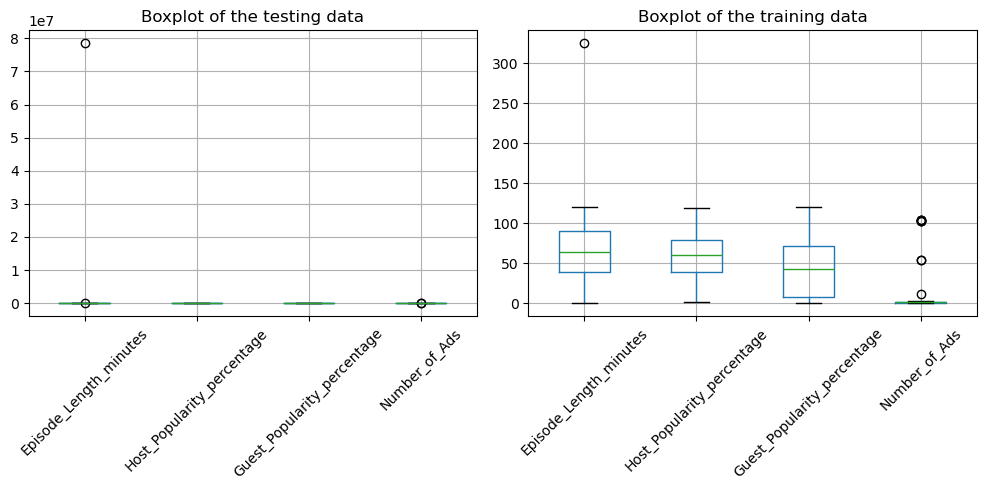

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
test_copy[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the testing data")
plt.subplot(1,2,2)
train_copy[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the training data")
plt.tight_layout()
plt.show()

In [ ]:
def skewed(data, columns):
    for col in columns:
        print(f"The skewness of the {col} is {data[col].skew()}")

In [ ]:
print('Training data')
skewed(train_copy, num_without_id)
print('Testing data')
skewed(test_copy, num_without_id)

Training data
The skewness of the Episode_Length_minutes is 0.00612298851900742
The skewness of the Host_Popularity_percentage is 0.004926275346942243
The skewness of the Guest_Popularity_percentage is 0.12004205501763875
The skewness of the Number_of_Ads is 6.032995851780484
Testing data
The skewness of the Episode_Length_minutes is 499.9999638772983
The skewness of the Host_Popularity_percentage is 0.011749553531104412
The skewness of the Guest_Popularity_percentage is 0.1229537993930891
The skewness of the Number_of_Ads is 448.86746290951714


[]

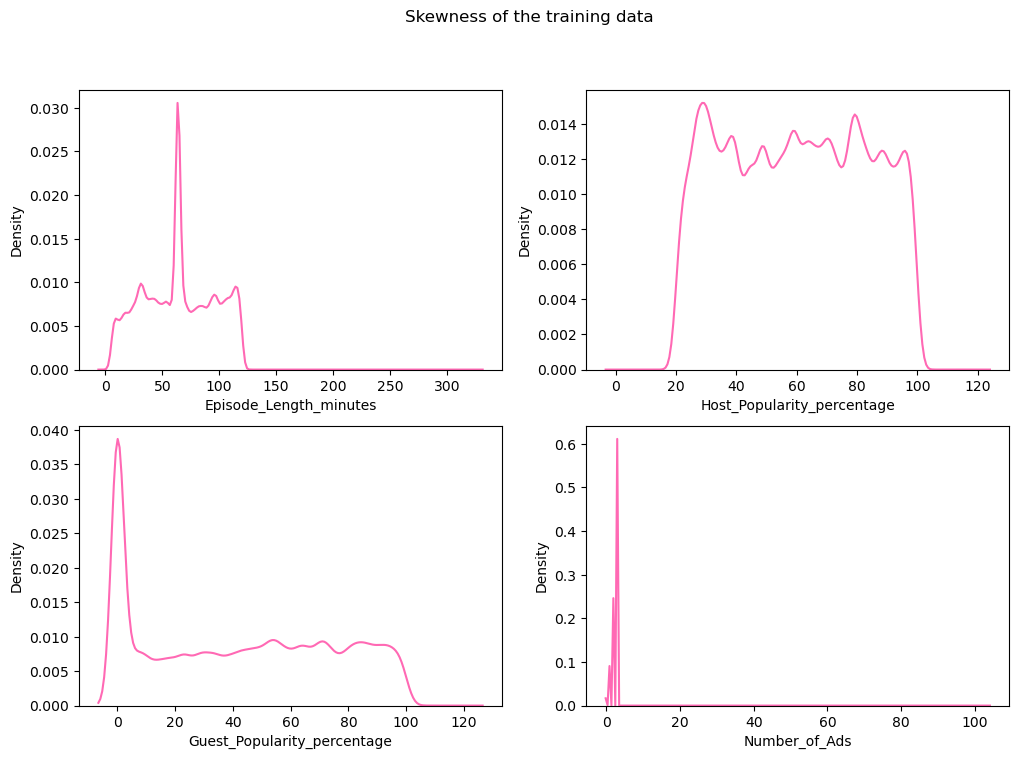

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(train_copy['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(train_copy['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(train_copy['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(train_copy['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the training data")
plt.plot()

[]

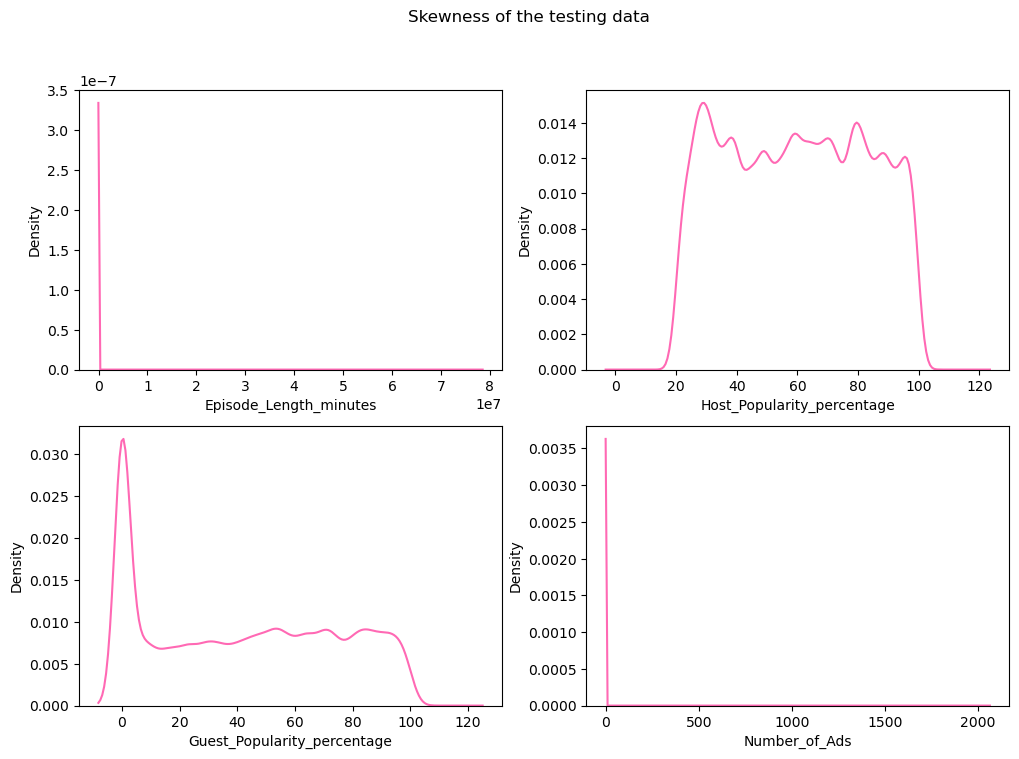

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(test_copy['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(test_copy['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(test_copy['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(test_copy['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the testing data")
plt.plot()

### Insights:
1. There is no such a big amount of outliers, but they are anomaly big, so it is important to deal with them
2. The `Guest_Popularity_percentage` and the `Host_Popularity_percentage` columns have very similar skewness both in training and testing data, they are close to the normal distribution
3. `Number_of_Abs` column is right-skewed in both data sets, but the testing set has much higher value of skew then the training set
4. `Episode_Length_minutes` is right-skewed in the testing data and has huge value of skew, but in the training data this column is close to the normal distribution

## 4.2 Dealing with outliers

**There are some values in columns with percentage that are higher then 100, so it is uncorrect**

In [ ]:
def replace(data, value_up, value_low, columns):
    data_copy = data.copy()
    for column in columns:
        up_mask = data_copy[column] > value_up
        if up_mask.any():
            data_copy.loc[up_mask, column] = value_up
            print(f"{column}: replaced {up_mask.sum()} values with {value_up}")
        low_mask = data_copy[column] < value_low
        if low_mask.any():
            data_copy.loc[low_mask, column] = value_low
            print(f"{column}: replaced {low_mask.sum()} values with {value_low}")
    return data_copy

In [ ]:
X_train = train_copy[num_without_id]
X_test = test_copy[num_without_id]
percentage_cols = ['Guest_Popularity_percentage', 'Host_Popularity_percentage']
X_train_replaced_percentage = replace(X_train, 100,0,percentage_cols)
X_test_replaced_percentage = replace(X_test, 100,0,percentage_cols)

Guest_Popularity_percentage: replaced 19 values with 100
Host_Popularity_percentage: replaced 25 values with 100
Guest_Popularity_percentage: replaced 5 values with 100
Host_Popularity_percentage: replaced 12 values with 100


In [ ]:
X_train_replaced_percentage[percentage_cols].describe()

,Guest_Popularity_percentage,Host_Popularity_percentage
count,750000.000000,750000.000000
mean,42.065402,59.859482
std,32.858344,22.872221
min,0.000000,1.300000
25%,7.850000,39.410000
50%,42.200000,60.050000
75%,71.040000,79.530000
max,100.000000,100.000000


In [ ]:
X_test_replaced_percentage[percentage_cols].describe()

,Guest_Popularity_percentage,Host_Popularity_percentage
count,250000.000000,250000.000000
mean,41.997790,59.716117
std,32.851138,22.879264
min,0.000000,2.490000
25%,7.790000,39.250000
50%,42.090000,59.900000
75%,70.990000,79.390000
max,100.000000,100.000000


In [ ]:
X_test = X_test_replaced_percentage
X_train = X_train_replaced_percentage

In [ ]:
def replace_outliers(train_data, test_data, columns):
    data_replaced_train = train_data.copy()
    data_replaced_test = test_data.copy()
    for column in columns:
        col_data_train = train_data[column]
        data_std = statistics.stdev(col_data_train)
        data_mean = statistics.mean(col_data_train)
        anomaly_cut_off = data_std * 3
        lower_limit = round(data_mean - anomaly_cut_off, 2)
        upper_limit = round(data_mean + anomaly_cut_off, 2)
        data_replaced_train = replace(data_replaced_train, upper_limit, lower_limit, [column])
        data_replaced_test = replace(data_replaced_test, upper_limit, lower_limit, [column])
    return data_replaced_train, data_replaced_test

In [ ]:
outlier_cols = ['Episode_Length_minutes', 'Number_of_Ads']
X_train_replaced, X_test_replaced = replace_outliers(X_train, X_test, outlier_cols)

Episode_Length_minutes: replaced 1 values with 157.41
Episode_Length_minutes: replaced 2 values with 157.41
Number_of_Ads: replaced 9 values with 4.8
Number_of_Ads: replaced 2 values with 4.8


In [ ]:
X_train_replaced = X_train_replaced.round({'Number_of_Ads':0})
X_test_replaced = X_test_replaced.round({'Number_of_Ads':0})

In [ ]:
X_train_replaced[outlier_cols].describe()

,Episode_Length_minutes,Number_of_Ads
count,750000.000000,750000.000000
mean,64.419194,1.347928
std,30.995881,1.111032
min,0.000000,0.000000
25%,39.420000,0.000000
50%,63.770000,1.000000
75%,90.310000,2.000000
max,157.410000,5.000000


In [ ]:
X_test_replaced[outlier_cols].describe()

,Episode_Length_minutes,Number_of_Ads
count,250000.000000,250000.000000
mean,64.458749,1.347284
std,31.003361,1.112713
min,2.470000,0.000000
25%,39.370000,0.000000
50%,63.770000,1.000000
75%,90.510000,2.000000
max,157.410000,5.000000


In [ ]:
X_test = X_test_replaced
X_train = X_train_replaced

**New value of skewness**

In [ ]:
print('Training data')
skewed(X_train, num_without_id)
print('Testing data')
skewed(X_test, num_without_id)

Training data
The skewness of the Episode_Length_minutes is 0.005386980199728367
The skewness of the Host_Popularity_percentage is 0.0047382817591158375
The skewness of the Guest_Popularity_percentage is 0.11997944053902403
The skewness of the Number_of_Ads is 0.21836520262894474
Testing data
The skewness of the Episode_Length_minutes is 0.004099249956181506
The skewness of the Host_Popularity_percentage is 0.011593305493045221
The skewness of the Guest_Popularity_percentage is 0.1228795432512219
The skewness of the Number_of_Ads is 0.21868805990274195


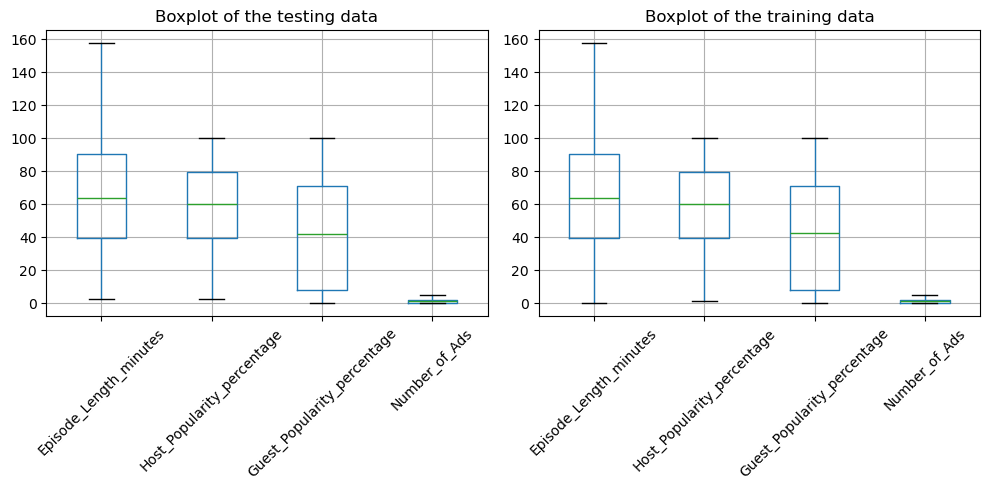

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
X_test.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the testing data")
plt.subplot(1,2,2)
X_train.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the training data")
plt.tight_layout()
plt.show()

[]

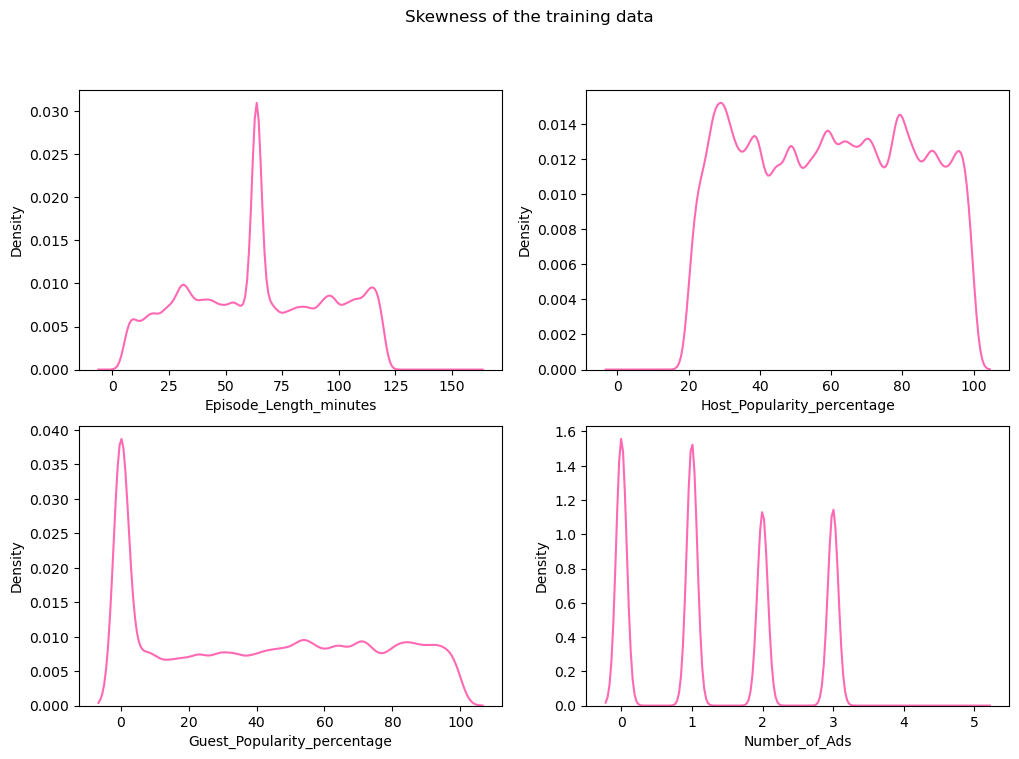

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(X_train['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(X_train['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(X_train['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(X_train['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the training data")
plt.plot()

[]

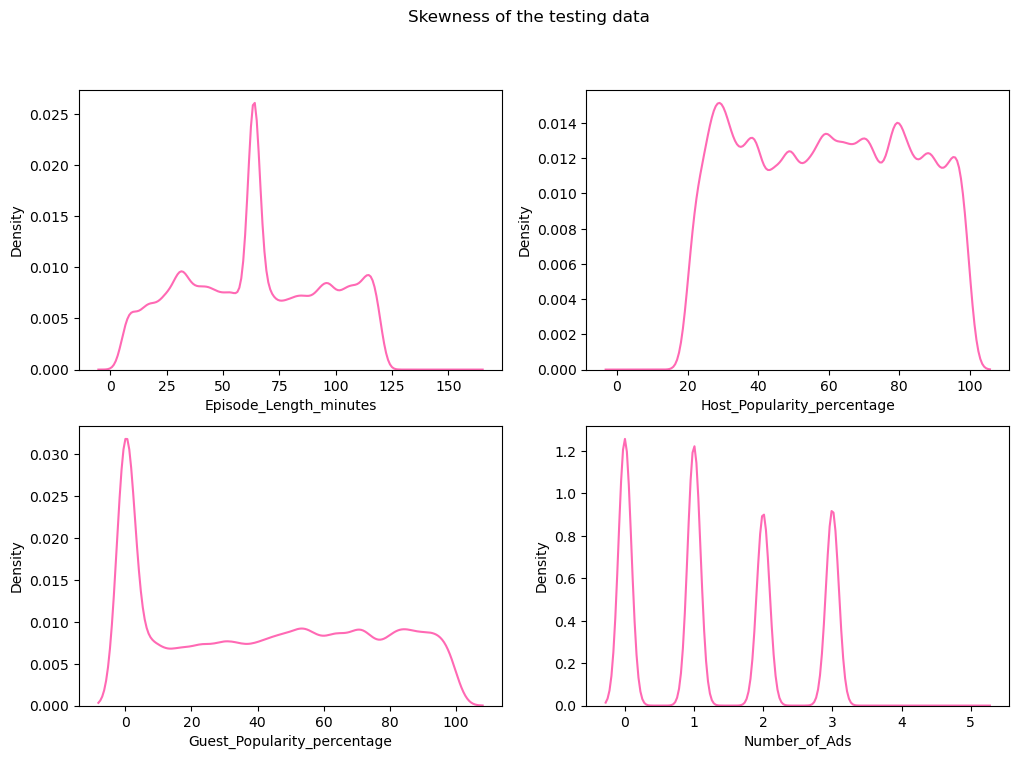

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(X_test['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(X_test['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(X_test['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(X_test['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the testing data")
plt.plot()

**Insights:**
- Now the data isn't contain any anomaly huge values, so it is clean and all columns are close to the normal distribution.

In [ ]:
train_copy[num_without_id] = X_train
test_copy[num_without_id] = X_test

In [ ]:
episode_completion = train_copy.groupby('Podcast_Name')['Episode_Title'].nunique()
print(episode_completion)

Podcast_Name
Athlete's Arena        100
Brain Boost            100
Business Briefs        100
Business Insights      100
Comedy Corner          100
Crime Chronicles       100
Criminal Minds         100
Current Affairs        100
Daily Digest           100
Detective Diaries      100
Digital Digest         100
Educational Nuggets    100
Fashion Forward        100
Finance Focus          100
Fitness First          100
Funny Folks            100
Gadget Geek            100
Game Day               100
Global News            100
Health Hour            100
Healthy Living         100
Home & Living          100
Humor Hub              100
Innovators             100
Joke Junction          100
Laugh Line             100
Learning Lab           100
Life Lessons           100
Lifestyle Lounge       100
Market Masters         100
Melody Mix             100
Mind & Body            100
Money Matters          100
Music Matters          100
Mystery Matters        100
News Roundup           100
Sound Waves    

In [ ]:
episode_completion_test = test_copy.groupby('Podcast_Name')['Episode_Title'].nunique()
print(episode_completion_test)

Podcast_Name
Athlete's Arena        100
Brain Boost            100
Business Briefs        100
Business Insights      100
Comedy Corner          100
Crime Chronicles       100
Criminal Minds         100
Current Affairs        100
Daily Digest           100
Detective Diaries      100
Digital Digest         100
Educational Nuggets    100
Fashion Forward        100
Finance Focus          100
Fitness First          100
Funny Folks            100
Gadget Geek            100
Game Day               100
Global News            100
Health Hour            100
Healthy Living         100
Home & Living          100
Humor Hub              100
Innovators             100
Joke Junction          100
Laugh Line             100
Learning Lab           100
Life Lessons           100
Lifestyle Lounge       100
Market Masters         100
Melody Mix             100
Mind & Body            100
Money Matters          100
Music Matters          100
Mystery Matters        100
News Roundup           100
Sound Waves    

**That means that all podcasts have 100 episodes**

**All episodes have names like this 'Episode_Number', so we can convert this column into numerical**

In [ ]:
train_copy['Episode_Title'] = train_copy['Episode_Title'].str.extract('(\d+)').astype(int)
train_copy['Episode_Title'].head()
test_copy['Episode_Title'] = test_copy['Episode_Title'].str.extract('(\d+)').astype(int)
test_copy['Episode_Title'].head()

0    73
1    23
2    11
3    73
4    50
Name: Episode_Title, dtype: int64

# 6. Data Visualization and Correlation Analysis

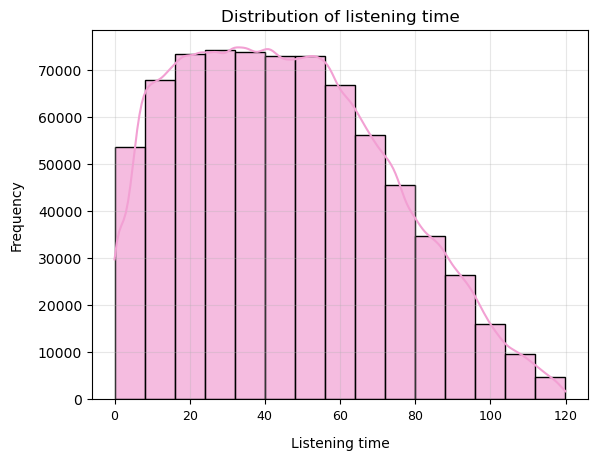

In [ ]:
sns.histplot(train_copy['Listening_Time_minutes'], bins=15, alpha=0.7, edgecolor='black', color='#F2A0D3', kde=True)
plt.xlabel('Listening time', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of listening time')
plt.grid(True, alpha=0.3)
plt.show()

**Insights:**
- The most popular listening time is around 20 and 50 minutes. 
- As listening time increases, the frequency gradually declines.
- The KDE is shifted to the left, meaning that users usually don't listen for very long.

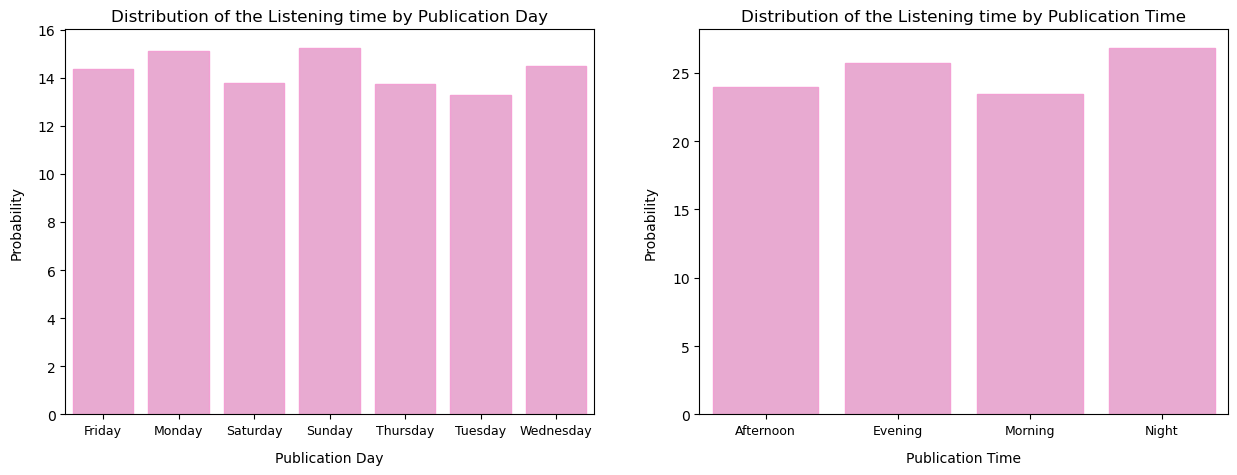

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
train_listening_publication_day = train_copy.groupby("Publication_Day")['Listening_Time_minutes'].sum()
train_listening_publication_day_prob = train_listening_publication_day / train_listening_publication_day.sum() *100
sns.barplot(x=train_listening_publication_day_prob.index, y=train_listening_publication_day_prob.values, color="#F2A0D3", edgecolor="#F2A0D3")
plt.xlabel('Publication Day', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Day')

plt.subplot(1, 2, 2)
train_listening_publication_time = train_copy.groupby("Publication_Time")['Listening_Time_minutes'].sum()
train_listening_publication_time_prob = train_listening_publication_time / train_listening_publication_time.sum() * 100
sns.barplot(x=train_listening_publication_time_prob.index, y=train_listening_publication_time_prob.values, color="#F2A0D3", edgecolor="#F2A0D3")
plt.xlabel('Publication Time', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Time')
plt.show()

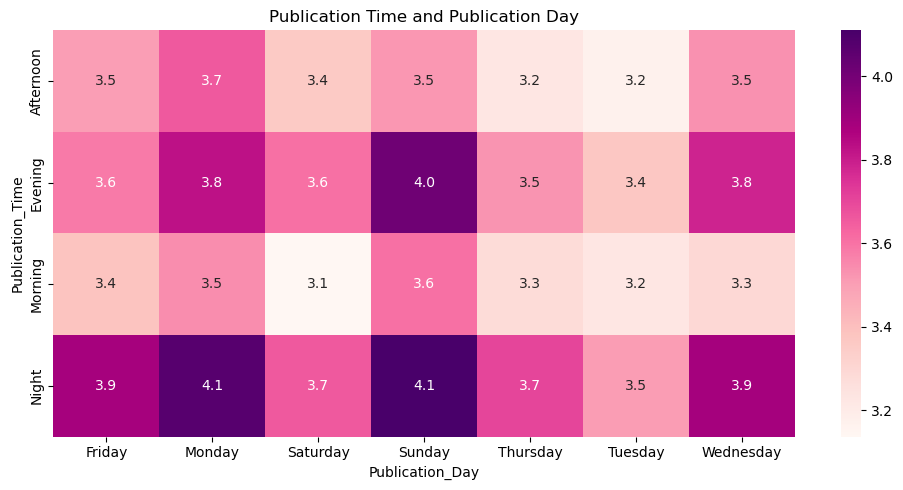

In [ ]:
plt.figure(figsize=(10, 5))
cross_tab = pd.crosstab(train_copy['Publication_Time'], train_copy['Publication_Day'], aggfunc='sum', values=train_copy['Listening_Time_minutes'], normalize=True)
sns.heatmap(cross_tab * 100, annot=True, fmt=".1f", cmap='RdPu')
plt.title("Publication Time and Publication Day")
plt.tight_layout()
plt.show()

**Insights:**
1. There are no significant differences and dependences between the distributions by specific days of the week and publication times, but the highest values ​​are observed on Mondays and Sundays, as well as at night and in the evening.
2. The most active time is Sunday Nights and Evenings and Moday Nights.

In [ ]:
selected_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                     'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes', 'Episode_Title']

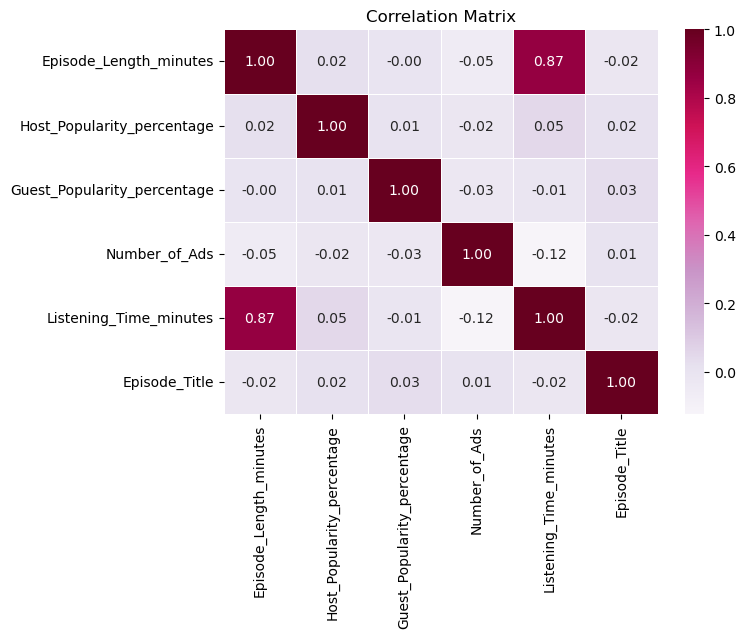

In [ ]:
corr_matrix_train = train_copy[selected_features].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix_train, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

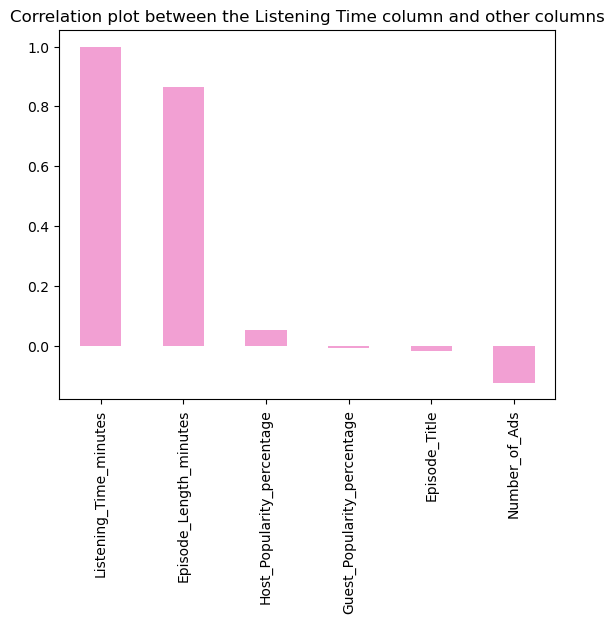

In [ ]:
corr_matrix_train['Listening_Time_minutes'].sort_values(ascending=False).plot(kind='bar', color='#F2A0D3')
plt.title("Correlation plot between the Listening Time column and other columns")
plt.show()

**Insights:**
- There is a strong positive correlation between `Episode_Length_minutes` and `Listening_Time_minutes` (0.87)
- Between `Number_of_Ads` and `Listening_Time_minutes` there is a negative correlation (-0.12)
- Other variables have correlations with `Listening_Time_minutes` approximately 0, so they are not so significant

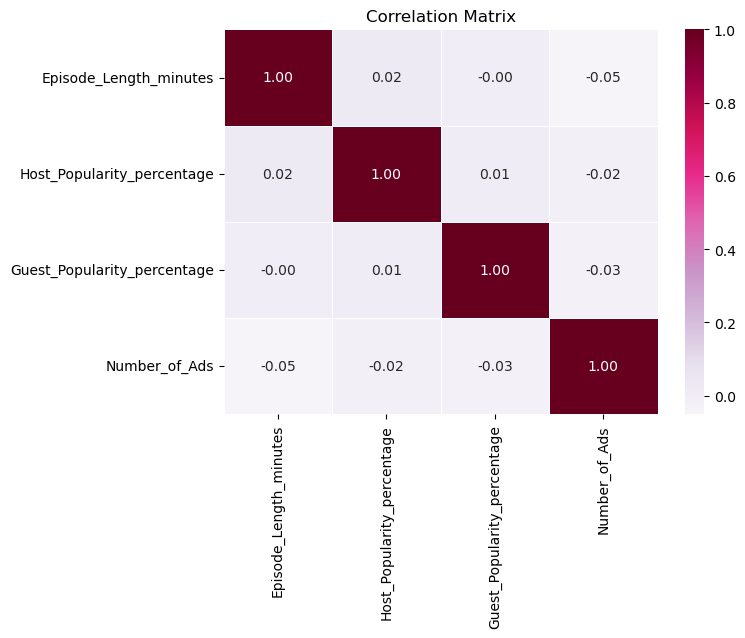

In [ ]:
corr_matrix = test_copy[num_without_id].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Number of Ads**

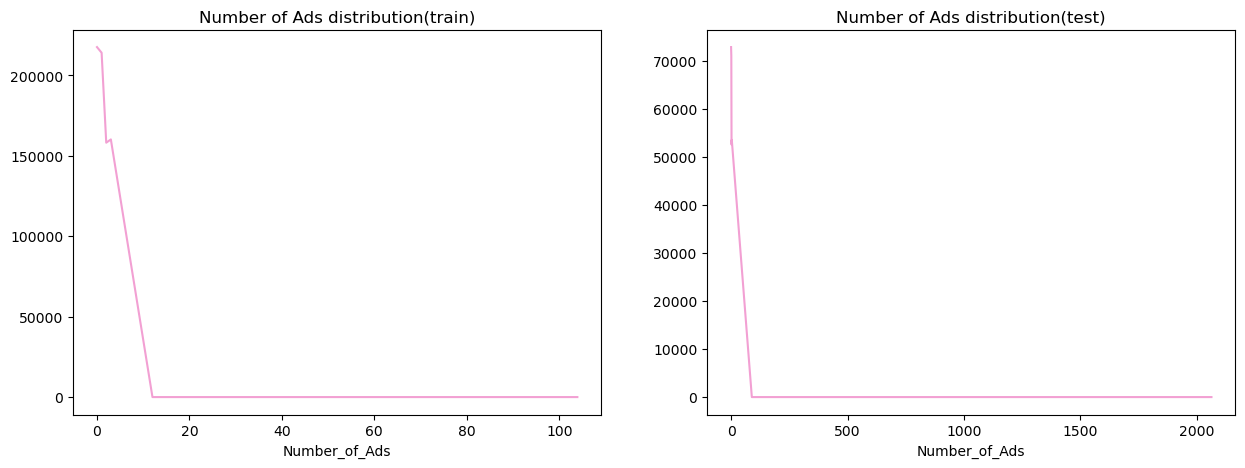

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Number of Ads distribution(train)")
train['Number_of_Ads'].value_counts().sort_index(ascending=True).plot(color='#F2A0D3')
plt.subplot(1,2,2)
test['Number_of_Ads'].value_counts().sort_index(ascending=True).plot(color='#F2A0D3')
plt.title("Number of Ads distribution(test)")
plt.show()

**Insights:**

- Most podcasts contain few ads.

- There are a small number of podcasts with very high numbers of ads, which form the long tail on the right.

- The distribution of the column `Number_of_Ads` is left-skewed and is similar for both training and testing set


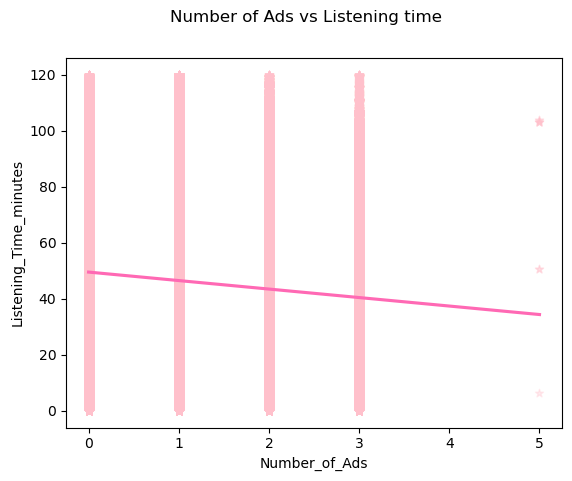

In [ ]:
sns.regplot(data=train_copy, x='Number_of_Ads', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Number of Ads vs Listening time")
plt.show()

**Insights:**
- As Number_of_Ads is increasing, the listening time is slightly decreasing

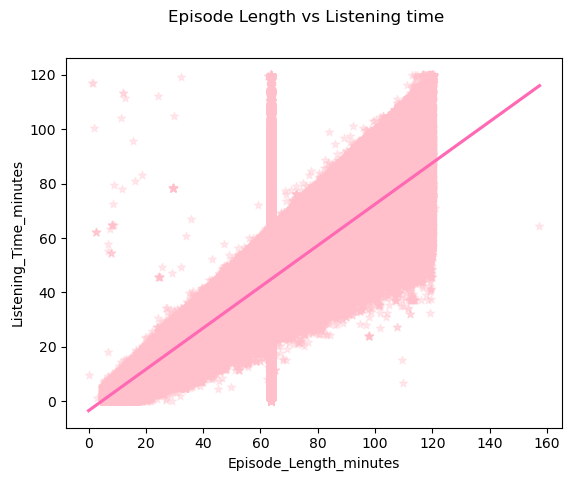

In [ ]:
sns.regplot(data=train_copy, x='Episode_Length_minutes', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Episode Length vs Listening time")
plt.show()

### Insights:
- As Episode Length is increasing, Listening time is increasing too

# 7. Feature Engineering

**There is very low correlation between `Host_Popularity_percentage`, `Guest_Popularity_percentage` and `Listening_Time_minutes`, so it is important to try to combine those features or add some new**

In [ ]:
train_copy_2 = train_copy.copy()
train_copy_2['Host_Guest_Combo'] = train_copy_2['Host_Popularity_percentage'] * train_copy_2['Guest_Popularity_percentage']
train_copy_2[['Host_Guest_Combo', 'Listening_Time_minutes']].corr()

,Host_Guest_Combo,Listening_Time_minutes
Host_Guest_Combo,1.000000,0.012525
Listening_Time_minutes,0.012525,1.000000


In [ ]:
train_copy_2['Popularity_Balance'] = (train_copy_2['Host_Popularity_percentage'] - train_copy_2['Guest_Popularity_percentage']).abs()
train_copy_2[['Popularity_Balance', 'Listening_Time_minutes']].corr()

,Popularity_Balance,Listening_Time_minutes
Popularity_Balance,1.00000,0.02697
Listening_Time_minutes,0.02697,1.00000


In [ ]:
train_copy_2['Popularity_Avg'] = (train_copy_2['Host_Popularity_percentage'] + train_copy_2['Guest_Popularity_percentage']) / 2
train_copy_2[['Popularity_Avg', 'Listening_Time_minutes']].corr()

,Popularity_Avg,Listening_Time_minutes
Popularity_Avg,1.000000,0.021295
Listening_Time_minutes,0.021295,1.000000


In [ ]:
genre_host_avg = train_copy_2.groupby('Genre')['Host_Popularity_percentage'].mean()
genre_guest_avg = train_copy_2.groupby('Genre')['Guest_Popularity_percentage'].mean()

train_copy_2['Host_Guest_Above_Genre'] = (train_copy_2['Host_Popularity_percentage'] > train_copy_2['Genre'].map(genre_host_avg)).astype(int)
train_copy_2['Guest_Above_Genre'] = (train_copy_2['Guest_Popularity_percentage'] > train_copy_2['Genre'].map(genre_guest_avg)).astype(int)
train_copy_2[['Host_Guest_Above_Genre', 'Guest_Above_Genre', 'Listening_Time_minutes']].corr()

,Host_Guest_Above_Genre,Guest_Above_Genre,Listening_Time_minutes
Host_Guest_Above_Genre,1.000000,0.005439,0.042846
Guest_Above_Genre,0.005439,1.000000,-0.015554
Listening_Time_minutes,0.042846,-0.015554,1.000000


In [ ]:
median_host = train_copy_2['Host_Popularity_percentage'].median()
median_guest = train_copy_2['Host_Popularity_percentage'].median()
train_copy_2['Popular'] = ((train_copy_2['Host_Popularity_percentage'] > median_host) | (train_copy_2['Guest_Popularity_percentage'] > median_guest)).astype(int)

train_copy_2['Host_Dominates'] = (train_copy_2['Host_Popularity_percentage'] > train_copy_2['Guest_Popularity_percentage']).astype(int)
train_copy_2[['Host_Dominates', 'Listening_Time_minutes', 'Popular']].corr()

,Host_Dominates,Listening_Time_minutes,Popular
Host_Dominates,1.000000,0.029449,-0.124584
Listening_Time_minutes,0.029449,1.000000,0.027784
Popular,-0.124584,0.027784,1.000000


**Those combinations are not really helpful**

In [ ]:
train_copy_2['Ads_per_Popularity'] = train_copy_2['Number_of_Ads'] / (train_copy_2['Host_Popularity_percentage'] + 0.1)
train_copy_2[['Ads_per_Popularity', 'Listening_Time_minutes']].corr()

,Ads_per_Popularity,Listening_Time_minutes
Ads_per_Popularity,1.000000,-0.108401
Listening_Time_minutes,-0.108401,1.000000


The correlation between `Ads_per_Popularity` and `Listening_Time_minutes` is negative(-0.11), that means if `Ads_per_Popularity` increases, `Listening_Time_minutes` decreases.This feature can be useful, so we can add to the main dataset.

In [ ]:
train_copy['Ads_per_Popularity'] = train_copy['Number_of_Ads'] / (train_copy['Host_Popularity_percentage'] + 0.1)
test_copy['Ads_per_Popularity'] = test_copy['Number_of_Ads'] / (test_copy['Host_Popularity_percentage'] + 0.1)

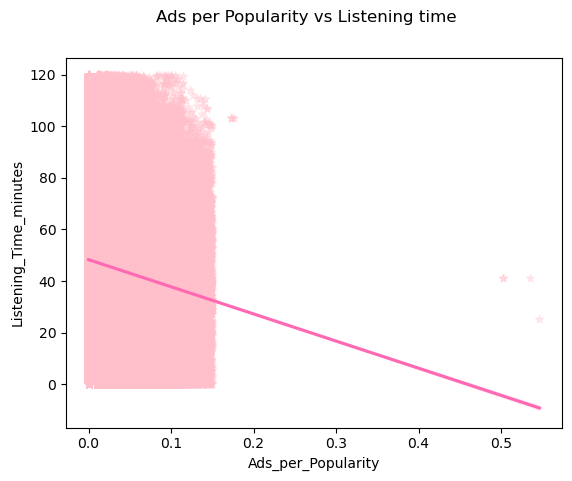

In [ ]:
sns.regplot(data=train_copy, x='Ads_per_Popularity', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Ads per Popularity vs Listening time")
plt.show()

In [ ]:
train_copy_2['Length_Popularity_Interaction'] = train_copy_2['Episode_Length_minutes'] * (train_copy_2['Host_Popularity_percentage']+train_copy_2['Guest_Popularity_percentage'])
train_copy_2['Length_Ads_Ratio'] = train_copy_2['Episode_Length_minutes'] / (train_copy_2['Number_of_Ads'] + 1)
train_copy_2[['Length_Popularity_Interaction','Length_Ads_Ratio' ,'Listening_Time_minutes']].corr()

,Length_Popularity_Interaction,Length_Ads_Ratio,Listening_Time_minutes
Length_Popularity_Interaction,1.000000,0.493017,0.654307
Length_Ads_Ratio,0.493017,1.000000,0.619844
Listening_Time_minutes,0.654307,0.619844,1.000000


The correlation between `Length_Popularity_Interaction` and `Listening_Time_minutes` is strong positive(0.65), that means if `Length_Popularity_Interaction` increases, `Listening_Time_minutes` aslo increases. The correlation between `Length_Ads_Ratio` and `Listening_Time_minutes` is strong positive(0.62), that means if `Length_Ads_Ratio` increases, `Listening_Time_minutes` aslo increases. Those features can be useful, so we can add to the main dataset.

In [ ]:
train_copy['Length_Ads_Ratio'] = train_copy['Episode_Length_minutes'] / (train_copy['Number_of_Ads'] + 1)
test_copy['Length_Ads_Ratio'] = test_copy['Episode_Length_minutes'] / (test_copy['Number_of_Ads'] + 1)

train_copy['Length_Popularity_Interaction'] = train_copy['Episode_Length_minutes'] * (train_copy['Host_Popularity_percentage']+train_copy['Guest_Popularity_percentage'])
test_copy['Length_Popularity_Interaction'] = test_copy['Episode_Length_minutes'] * (test_copy['Host_Popularity_percentage']+test_copy['Guest_Popularity_percentage'])

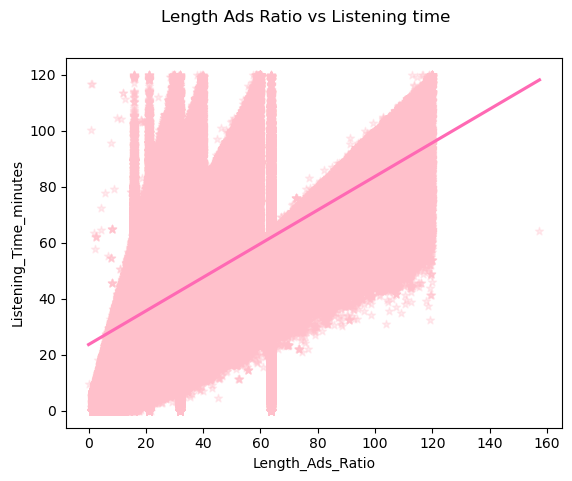

In [ ]:
sns.regplot(data=train_copy, x='Length_Ads_Ratio', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Length Ads Ratio vs Listening time")
plt.show()

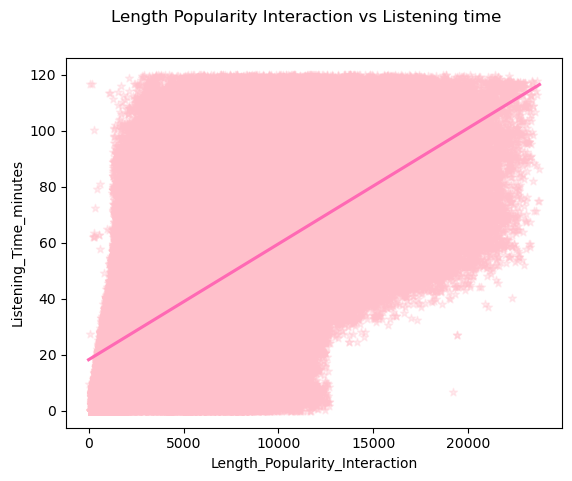

In [ ]:
sns.regplot(data=train_copy, x='Length_Popularity_Interaction', y='Listening_Time_minutes', line_kws={"color": "hotpink"}, color='pink', marker="*", scatter_kws={'alpha': 0.3})
plt.suptitle("Length Popularity Interaction vs Listening time")
plt.show()

In [ ]:
avg_lengths = train_copy_2.groupby('Podcast_Name')['Episode_Length_minutes'].mean().round(2)
train_copy_2['Avg_Episode_Length'] = train_copy_2['Podcast_Name'].map(avg_lengths)
new_corr_m = train_copy_2[['Avg_Episode_Length', 'Listening_Time_minutes']].corr()
new_corr_m


,Avg_Episode_Length,Listening_Time_minutes
Avg_Episode_Length,1.00000,0.04842
Listening_Time_minutes,0.04842,1.00000


In [ ]:
train_copy_2['is_Night_or_Evening'] = np.where(
    train_copy_2['Publication_Time'].isin(['Night', 'Evening']), 1, 0
)
train_copy_2[['is_Night_or_Evening', 'Listening_Time_minutes']].corr()

,is_Night_or_Evening,Listening_Time_minutes
is_Night_or_Evening,1.000000,0.006721
Listening_Time_minutes,0.006721,1.000000


In [ ]:
train_copy_2['Has_Guest'] = (
    (train_copy_2['Guest_Popularity_percentage'] > 0)
).astype(int)
train_copy_2[['Has_Guest', 'Listening_Time_minutes']].corr()

,Has_Guest,Listening_Time_minutes
Has_Guest,1.000000,0.002877
Listening_Time_minutes,0.002877,1.000000


**The feature `Avg_Episode_Length` has very small value of correlation with `Listening_Time_minutes`, so it doesn't help much if adding this new feature.**

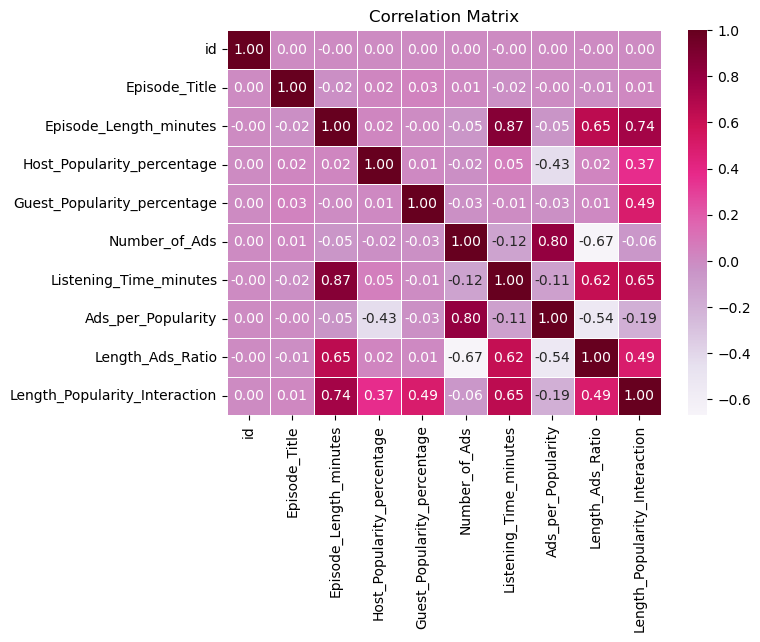

In [ ]:
corr_matrix_train = train_copy.corr(numeric_only=True)
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix_train, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**The most significant columns that have strong correlation with target are `Episode_Length_minutes`, `Number_of_Ads`, `Length_Ads_Ratio`, `Ads_per_Popularity`, `Length_Popularity_Interaction`**

Now we have new features, that have strong correlation with target, but some features have very low correlation with target, so if we delete them, we can lose some information (but id column doesn't have important information, so we can delete `id` column), that means non-linear dependences between other features, so it is important to try not-linear models, such as:
1. Tree-Based Models
2. Gradient Boosting
3. Ensemble Methods

**We don't need to use feature scaling for those models**

In [ ]:
train_X = train_copy.drop(['id', 'Listening_Time_minutes'], axis=1)
test_X = test_copy.drop('id', axis=1)
train_y = train_copy['Listening_Time_minutes']

In [ ]:
train_podcasts = set(train_copy['Podcast_Name'].unique())
test_podcasts = set(test['Podcast_Name'].unique())

print(f"Train podcasts: {len(train_podcasts)}")
print(f"Test podcasts: {len(test_podcasts)}")
print(f"Intersection: {len(train_podcasts & test_podcasts)}")
print(f"Only in train: {len(train_podcasts - test_podcasts)}")
print(f"Only in test: {len(test_podcasts - train_podcasts)}")

Train podcasts: 48
Test podcasts: 48
Intersection: 48
Only in train: 0
Only in test: 0


### All podcasts in training set are also in testing set

In [ ]:
podcast_means = train_copy.groupby('Podcast_Name')['Listening_Time_minutes'].mean()

print("Statistics by podcasts (train):")
print(f"Average time: {podcast_means.mean():.1f} min")
print(f"Range: {podcast_means.min():.1f} - {podcast_means.max():.1f} min")
print(f"Standard devation: {podcast_means.std():.1f} min")

Statistics by podcasts (train):
Average time: 45.4 min
Range: 41.8 - 48.1 min
Standard devation: 1.4 min


In [ ]:
genre_means = train_copy.groupby('Genre')['Listening_Time_minutes'].mean()

print("Statistics by genre (train):")
print(f"Average time: {genre_means.mean():.1f} min")
print(f"Range: {genre_means.min():.1f} - {genre_means.max():.1f} min")
print(f"Standard devation: {genre_means.std():.1f} min")

Statistics by genre (train):
Average time: 45.5 min
Range: 44.4 - 46.6 min
Standard devation: 0.7 min


**Different Podcasts and Genres not significantly different by listening time** 

# 8. Label encoding

- The columns `Episode_Sentiment`, `Publication_Day` and `Publication_Time` have ordinal values, so the best ordinal of the encoder will be Label Encoder
- The column `Genre` and `Podcasts_Name` have nominal values, but they are not significantly differences from each other by listening time, so the best option will be also Label Encoder

In [ ]:
ordinal_columns = ['Episode_Sentiment', 'Publication_Day', 'Publication_Time', 'Podcast_Name', 'Genre']

label_encoders = {}
for col in ordinal_columns:
    le = LabelEncoder()
    train_X[f'{col}_Encoded'] = le.fit_transform(train_X[col])
    test_X[f'{col}_Encoded'] = le.transform(test_X[col])
    label_encoders[col] = le
train_X = train_X.drop(ordinal_columns, axis=1)
test_X = test_X.drop(ordinal_columns, axis=1)

In [ ]:
train_X.head()

,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Ads_per_Popularity,Length_Ads_Ratio,Length_Popularity_Interaction,Episode_Sentiment_Encoded,Publication_Day_Encoded,Publication_Time_Encoded,Podcast_Name_Encoded,Genre_Encoded
0,98,63.77,74.81,0.00,0.0,0.000000,63.770000,4770.6337,2,4,3,34,9
1,26,119.80,66.95,75.95,2.0,0.029828,39.933333,17119.4200,0,2,0,24,1
2,16,73.90,69.97,8.97,0.0,0.000000,73.900000,5833.6660,0,5,1,40,2
3,45,67.17,57.22,78.70,2.0,0.034892,22.390000,9129.7464,2,1,2,10,8
4,86,110.51,80.07,58.68,3.0,0.037420,27.627500,15333.2625,1,1,0,31,3


In [ ]:
test_X.head()

,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Ads_per_Popularity,Length_Ads_Ratio,Length_Popularity_Interaction,Episode_Sentiment_Encoded,Publication_Day_Encoded,Publication_Time_Encoded,Podcast_Name_Encoded,Genre_Encoded
0,73,78.96,38.11,53.33,1.0,0.026171,39.480000,7220.1024,1,2,1,11,2
1,23,27.87,71.29,0.00,0.0,0.000000,27.870000,1986.8523,1,3,2,36,5
2,11,69.10,67.89,97.51,0.0,0.000000,69.100000,11429.1400,2,0,1,24,1
3,73,115.39,23.40,51.75,2.0,0.085106,38.463333,8671.5585,2,3,2,4,1
4,50,72.32,58.10,11.30,2.0,0.034364,24.106667,5019.0080,1,6,2,27,4


# 8. General Observations and Summary

1. There were big amount of nullable values, so I choose and applied the best imputer (Simple Imputer)
2. I have converted column `Episode_Title` into numerical one
3. There were some very huge outliers, so I cleaned the data
4. In columns with percentage there were some values that are bigger then 100, I have replaced them with 100
5. The most important numerical columns in our data set are `Episode_Length_minutes` and `Number_of_Ads`. It is also important to add columns `Length_Ads_Ratio`, `Ads_per_Popularity` and `Length_Popularity_Interaction`
6. The training set and the testing set have a similar distribution based on metrics, which significantly improves analysis and prediction
7. I have deleted column `Id` that haven't any influence into `Listening_Time_minutes` column
8. I have applied Label Encoder for categorical columns

Some features have very low correlation with target, so it is important to try not-linear models, such as:
1. Tree-Based Models
2. Gradient Boosting
3. Ensemble Methods